# Step 3. Feature Engineering

verion 2.0, August 1a
2018

1. List of possible features
2. Process ADAMS sub-sample
3. Process HRS 2000 data

**FINAL DATASET and FEATURES: `model_data_hrs.csv`**


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import recode_functions as rf

LOCAL_DIR = '/home/jovyan/notebook/'


## A. Basic Features

In [2]:
header = ['hhidpn', 
          'brain_health_diag1', 
          'brain_health_diag2',
          'brain_health_1', 
          'brain_health_2',
          'brain_health_3',
          'total_cog', 'total_recall', 'serial7','tics','backwards_20','immediate_recall','delayed_recall',
          'g1101',  # age
          'g1074a', # education yrs
          'g1158',  # marital status
          'g1092a', # race
          'g1087', #### dad's education
          'g1088', #### mother's education
          'g1085',  #### Added lived with grandparents
          'g1142',  #### Importance of religion
         ]

## B. ADAMS Sub-Sample

(Note the full sample n = 1770 and one with respondents n = 856)

### Loading Data

In [3]:
# Load data 
#table_full = pd.read_csv('/home/levi/data/brainFitDx/data/sample/final_adams_hrs_combined.csv')
table_small = pd.read_csv(LOCAL_DIR + 'brainFitDx/data/sample/final_adams_hrs_combined_small.csv')

In [4]:
#table_full.info()

In [5]:
table_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Columns: 13502 entries, HHID to brain_health_3
dtypes: float64(13391), int64(87), object(24)
memory usage: 88.2+ MB


In [6]:
#table_full.loc[:,['hhidpn', 'ADCCDX1', 'ADFDX1','brain_health_1','brain_health_2','brain_health_3',
#                  'total_cog', 'total_recall', 'serial7','tics']].head(5)

In [7]:
table_small.loc[:,['hhidpn', 'ADCCDX1', 'ADFDX1','brain_health_1','brain_health_2','brain_health_3',
                  'total_cog', 'total_recall', 'serial7','tics']].head(5)

,hhidpn,ADCCDX1,ADFDX1,brain_health_1,brain_health_2,brain_health_3,total_cog,total_recall,serial7,tics
0,10059030,31.0,31.0,1,2,1,0.0,0,0,0.0
1,12513010,21.0,21.0,0,1,1,16.0,7,0,9.0
2,12588020,31.0,31.0,0,0,0,26.0,11,5,10.0
3,13140010,31.0,31.0,0,0,0,24.0,12,2,10.0
4,13857010,31.0,31.0,0,0,0,23.0,11,3,9.0


### Recoding features

* ADAMS diagnosis, `ADFXD1, brain_health_diag1, brain_health_diag2`

In [8]:
df = table_small

In [9]:
# recode dementia diagnosis (3 levels)
# normal: 31
# cognitive impairment: 20-30, 32, 33
# dementia: 1-19

brain_health_diag1=rf.initialize_series(df)
indices=rf.get_indices([df['ADFDX1'].between(1,19), # 2: dementia 
                        (df['ADFDX1'].between(20,30))|(df['ADFDX1'].between(32,33)) # 1: cognitive impairment
                       ])
brain_health_diag1=rf.update_series(brain_health_diag1, indices, values=[2, 1]) # 0: normal

In [10]:
brain_health_diag1.value_counts()

2    308
0    307
1    241
dtype: int64

In [11]:
# recode dementia diagnosis (2 levels)
# normal
# non-normal (cognitive impairment, dementia)
brain_health_diag2=rf.initialize_series(df)
indices=rf.get_indices([brain_health_diag1.between(1,2)])
brain_health_diag2=rf.update_series(brain_health_diag2, indices, values=[1]) # 1: non-normal   

In [12]:
brain_health_diag2.value_counts()

1    549
0    307
dtype: int64

In [13]:
df['brain_health_diag1'] = brain_health_diag1
df['brain_health_diag2'] = brain_health_diag2

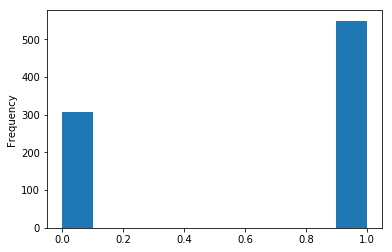

In [14]:
df['brain_health_diag2'].plot.hist()

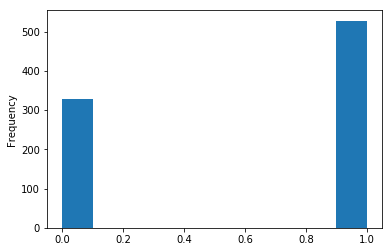

In [15]:
df['brain_health_3'].plot.hist()

* Demographic variables

In [16]:
df['g1074a'].isnull().sum()

10

**Note the 10 (full sample 35) participants who don't have HRS 2000 data. DROP AT END **

In [17]:
#df = df.loc[df['g1101'].notna(),:]

In [18]:
# Age
df['g1101'].unique()

array([  72.,   69.,   68.,   82.,   nan,   77.,   73.,   70.,   76.,
         74.,   67.,   71.,   75.,   80.,   78.,   79.,   85.,   93.,
         87.,   81.,   86.,   98.,  104.,   89.,   88.,   92.,   95.,
         83.,   84.,   91.,   94.,   90.,   96.,  102.,  100.,   97.,  107.])

In [19]:
# Yr of education
df['g1074a'].unique()
df['g1074a'].value_counts()

12.0    189
8.0      96
10.0     61
14.0     54
17.0     51
13.0     49
9.0      43
16.0     42
11.0     41
0.0      39
3.0      30
7.0      29
4.0      28
5.0      27
6.0      22
15.0     21
2.0      14
1.0       7
97.0      3
Name: g1074a, dtype: int64

In [20]:
# recode
df.loc[:,'g1074a'].replace(to_replace=97., value=0,inplace=True)
df['g1074a'].value_counts()

12.0    189
8.0      96
10.0     61
14.0     54
17.0     51
13.0     49
9.0      43
16.0     42
0.0      42
11.0     41
3.0      30
7.0      29
4.0      28
5.0      27
6.0      22
15.0     21
2.0      14
1.0       7
Name: g1074a, dtype: int64

In [21]:
# recode marital status (G1158)
marital_status = rf.initialize_series(df)
indices = rf.get_indices([df['g1158']==1, # 1: married 
                        df['g1158'].between(3,5), # 2: separated/divorced/widowed
                        df['g1158']==6  # 3: never married
                       ]) 
marital_status = rf.update_series(marital_status, indices, values=[1,2,3]) # 0: don't know/other
marital_status.unique()
marital_status.value_counts()

2    460
1    363
3     20
0     13
dtype: int64

In [22]:
df.loc[:,'g1158'] = marital_status
df['g1158'].value_counts()

2    460
1    363
3     20
0     13
Name: g1158, dtype: int64

In [23]:
# examine race 
df['g1092a'].value_counts() # 82 missing values?

1.0    649
2.0    163
7.0     34
Name: g1092a, dtype: int64

In [24]:
# recode race (G1092A)
race=rf.initialize_series(df)
indices=rf.get_indices([df['g1092a']==1, # 1: white
                        df['g1092a']==2, # 2: black
                        df['g1089a']==1, # 3: hispanic
                        (df['g1089a']==5) & (df['g1092a']==7) # 4: other
                       ])
race=rf.update_series(race, indices, values=[1,2,3,4]) # 0: 82 values that are missing in raw variable

# grouping category 0 into other category
indices=rf.get_indices([race==0])
race=rf.update_series(race, indices, values=[4])
race.value_counts()

1    583
2    158
3     84
4     31
dtype: int64

In [25]:
df.loc[:,'g1092a'] = race
df['g1092a'].value_counts()

1    583
2    158
3     84
4     31
Name: g1092a, dtype: int64

In [26]:
df['g1087'].value_counts() 

98.0    4
8.0     2
10.0    2
6.0     2
12.0    2
14.0    1
7.0     1
Name: g1087, dtype: int64

In [27]:
# recode
df.loc[:,'g1087'].replace(to_replace=98., value=0,inplace=True)
df.loc[:,'g1087'].fillna(value=0, inplace=True)
df['g1087'].value_counts()

0.0     846
8.0       2
10.0      2
6.0       2
12.0      2
14.0      1
7.0       1
Name: g1087, dtype: int64

In [28]:
df['g1088'].value_counts() 

98.0    4
6.0     3
8.0     2
12.0    2
7.0     1
14.0    1
13.0    1
Name: g1088, dtype: int64

In [29]:
# recode
df.loc[:,'g1088'].replace(to_replace=98., value=0,inplace=True)
df.loc[:,'g1088'].fillna(value=0, inplace=True)
df['g1088'].value_counts()

0.0     846
6.0       3
8.0       2
12.0      2
7.0       1
14.0      1
13.0      1
Name: g1088, dtype: int64

In [30]:
# recode lived with grandparents (G1085)
lived_grands=rf.initialize_series(df)
indices=rf.get_indices([df['g1085']==1, # 1: yes
                        df['g1085'].between(8,9) # 2: other
                       ]) 
lived_grands=rf.update_series(lived_grands, indices, values=[1,2]) 
lived_grands.value_counts()

0    687
1    161
2      8
dtype: int64

In [31]:
df.loc[:,'g1085'] = lived_grands
df['g1085'].value_counts()

0    687
1    161
2      8
Name: g1085, dtype: int64

In [32]:
# recode religion (G1142)
religion=rf.initialize_series(df)
indices=rf.get_indices([df['g1142']==1, # 3: very important
                        df['g1142']==3, # 2: somewhat important
                        df['g1142']==5 # 1: not very important
                       ]) 
religion=rf.update_series(religion, indices, values=[3,2,1]) # 0: don't know, other
religion.value_counts()

3    581
2    175
1     86
0     14
dtype: int64

In [33]:
df.loc[:,'g1142'] = religion
df['g1142'].value_counts()

3    581
2    175
1     86
0     14
Name: g1142, dtype: int64

In [34]:
header

['hhidpn',
 'brain_health_diag1',
 'brain_health_diag2',
 'brain_health_1',
 'brain_health_2',
 'brain_health_3',
 'total_cog',
 'total_recall',
 'serial7',
 'tics',
 'backwards_20',
 'immediate_recall',
 'delayed_recall',
 'g1101',
 'g1074a',
 'g1158',
 'g1092a',
 'g1087',
 'g1088',
 'g1085',
 'g1142']

* Add in medical and other features

In [35]:
## Dictionary

YES = 1
NO = 5
DK = 0
RF = 0
NO_RESPONSE = 0

MUCH_BETTER = 1
BETTER = 2
SAME = 3
WORSE = 4
MUCH_WORSE = 5

EXCELLENT = 1
VERY_GOOD = 2
GOOD = 3
FAIR = 4
POOR = 5
BLIND = 6

GAINED = 1
LOST = 2
VOLATILE = 3

ONE_EYE = 1
TWO_EYES = 2

NEVER = 1
FEW = 2
MOST = 3
ALL = 4

ABSTAIN = 3

CATHETER = 31

PART_YEAR = 1

CANT = 1
DONT = 1

MARRIED = 1
OTHER = 2
NEVER = 3


# Define scales

ever_had = {1:YES, 3:YES, 4:NO, 5:NO, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
stroke_has = {1:YES, 2:YES, 3:YES, 4:NO, 5:NO, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
full_likert = {1:EXCELLENT, 2:VERY_GOOD, 3:GOOD, 4:FAIR, 5:POOR, 8:DK, 9:RF, 'Blank':NO_RESPONSE} 
likert6 = {1:EXCELLENT, 2:VERY_GOOD, 3:GOOD, 4:FAIR, 5:POOR, 6:BLIND, 8:DK, 9:RF, 'Blank':NO_RESPONSE} 
yes_no = {1:YES, 5:NO, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
better_worse = {1:BETTER, 2:SAME, 3:WORSE, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
weight_trend = {1:GAINED, 2:LOST, 3:VOLATILE, 5:NO, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
alcohol_has = {1:YES, 3:ABSTAIN, 5:NO, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
alcohol_ever ={1:NO_RESPONSE, 3:YES, 5:NO_RESPONSE, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
cataract_number = {1:ONE_EYE, 3:TWO_EYES, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
survey_assist =  {1:NEVER, 2:FEW, 3:MOST, 4:ALL, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
numeric10 = {8:DK, 9:RF, 'Blank':NO_RESPONSE}
numeric100 = {98:DK, 99:RF, 'Blank':NO_RESPONSE}
numeric1000 = {998:DK, 999:RF, 'Blank':NO_RESPONSE}
numeric10000 = {9998:DK, 9999:RF, 'Blank':NO_RESPONSE}
incontinence_num = {95:CATHETER, 98:DK, 99:RF, 'Blank':NO_RESPONSE}
stop_smoke = {96:PART_YEAR, 98:DK, 99:RF, 'Blank':NO_RESPONSE}
depression = {1:YES, 'Blank':NO_RESPONSE}
yes_no2 = {1:YES, 5:NO, 6:CANT, 7:DONT, 8:DK, 9:RF, 'Blank':NO_RESPONSE}
marital = {1:MARRIED, 2:OTHER, 3:OTHER, 4:OTHER, 5:OTHER, 6:NEVER, 'Blank':NO_RESPONSE}

all_scales = {'full_likert':full_likert, 'yes_no':yes_no, 'better_worse':better_worse, 'ever_had':ever_had, \
                'stroke_has': stroke_has, 'likert6':likert6, 'cataract_number':cataract_number, \
                'alcohol_ever':alcohol_ever, 'weight_trend':weight_trend, 'survey_assist':survey_assist, \
                'alcohol_has':alcohol_has, 'stop_smoke':stop_smoke, 'depression':depression, \
                'incontinence_num':incontinence_num, 'numeric10':numeric10, 'numeric100':numeric100, \
                'numeric1000':numeric1000, 'numeric10000':numeric10000, 'yes_no2':yes_no2, 'marital':marital \
             }


In [36]:
features_nonnum = pd.read_csv('features_NonNum.csv')
features_nonnum

,old_column,new_column,question_type,question
0,g1415,g1415,alcohol_ever,alcohol_ever
1,g1415,g1415,alcohol_has,alcohol_has
2,g1229,g1229,better_worse,past health
3,g1242,g1242,better_worse,hypertension_trend
4,g1252,g1252,better_worse,diabetes_trend
5,g1266,g1266,better_worse,cancer_trend
6,g1280,g1280,better_worse,lung_trend
7,g1292,g1292,better_worse,heart_trend
8,g1323,g1323,better_worse,psych_trend
9,g1374,g1374,better_worse,pain_rating


In [37]:
features_num = pd.read_csv('features_Numeric.csv')
features_num

,old_column,new_column,question_type,question
0,g1409,g1409,numeric10,smoke_high_packs
1,g1416,g1416,numeric10,alcohol_dayspw
2,g1428,g1428,numeric10,height feet
3,g1268,g1268,numeric100,cancer_num
4,g1340,g1340,numeric100,falls_num
5,g1402,g1402,numeric100,smoke_num_pack
6,g1404,g1404,numeric100,smoke_age
7,g1406,g1406,numeric100,smoke_start_years
8,g1413,g1413,numeric100,smoke_stop_age
9,g1417,g1417,numeric100,alcohol_dayspq


In [38]:
# Drop most cols
mask = '^hhidpn|^brain|^total|^serial|^tics|^backwards|^immediate|^delayed|^g[1-3]'
filter = df.keys().str.contains(mask, regex=True).tolist()
df = df.loc[:,filter].copy()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Columns: 2614 entries, hhidpn to brain_health_diag2
dtypes: float64(2599), int64(15)
memory usage: 17.1 MB


In [40]:
features = features_nonnum['old_column'].tolist() + features_num['old_column'].tolist()
features.sort()

### Process Features

In [41]:
# Process numeric features
for index, row in features_num.iterrows():
    df = rf.recode_numeric_column(df, row['old_column'], row['new_column'], row['question_type'], all_scales[row['question_type']])
    

In [42]:
# Process other features
for index, row in features_nonnum.iterrows():
    df = rf.recode_single_column(df, row['old_column'], row['new_column'], row['question_type'], all_scales[row['question_type']])

### Add in derived features


* Time for serial 7
* Recode for serial 7
* Proxy dummy variable (g1527?)
* Health trend
* BMI (lots of Nan)



In [43]:
# Time to do serial 7
df['g1814_05'] = df['g1814'] - df['g1805']

In [44]:
# Recode Serial 7
df.loc[df['g1806'].between(1,100), ['g1806']] = 5
df.loc[df['g1806'] == 93, ['g1806']] = 1

df.loc[df['g1807'].between(1,100), ['g1807']] = 5
df.loc[df['g1807'] == 86, ['g1807']] = 1

df.loc[df['g1808'].between(1,100), ['g1808']] = 5
df.loc[df['g1808'] == 79, ['g1808']] = 1

df.loc[df['g1809'].between(1,100), ['g1809']] = 5
df.loc[df['g1809'] == 72, ['g1809']] = 1

df.loc[df['g1810'].between(1,100), ['g1810']] = 5
df.loc[df['g1810'] == 65, ['g1810']] = 1


In [45]:
# Proxy
# g1527?

In [46]:
# Health trend
df = rf.recode_health_trend(df, 'g1229', 'g1233', 'g1234', 'g1_trend_health')

In [47]:
# BMI IN ADAMS ONLY 2 VALID VALUES
# df = rf.recode_bmi(df, 'g1425', 'g1428', 'g1429', 'bmi')

In [48]:
add_features = ['g1814_05', 'g1_trend_health']

## Process Full dataset

In [49]:
mask2 = header + add_features + features
print (len(mask2))

table_data = df[mask2]
table_data.info()
table_data.head()

235
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Columns: 235 entries, hhidpn to g3060
dtypes: float64(34), int64(201)
memory usage: 1.5 MB


,hhidpn,brain_health_diag1,brain_health_diag2,brain_health_1,brain_health_2,brain_health_3,total_cog,total_recall,serial7,tics,...,g2878,g2915,g2916,g2918,g2940,g2995,g2996,g2999,g3002,g3060
0,10059030,0,0,1,2,1,0.0,0,0,0.0,...,0,5,5,0,0.0,1,52.0,6.0,1,4.0
1,12513010,1,1,0,1,1,16.0,7,0,9.0,...,0,5,5,0,0.0,1,15.0,25.0,5,2.0
2,12588020,0,0,0,0,0,26.0,11,5,10.0,...,0,5,5,0,0.0,1,120.0,40.0,1,2.0
3,13140010,0,0,0,0,0,24.0,12,2,10.0,...,0,1,5,0,0.0,5,0.0,0.0,1,2.0
4,13857010,0,0,0,0,0,23.0,11,3,9.0,...,0,5,5,0,0.0,1,10.0,0.0,1,2.0


### Save Data


In [50]:
#table_data.to_csv(LOCAL_DIR + 'brainFitDx/data/sample/model_data_adams.csv', index=False)

## C. HRS 2000 
### Loading Data

In [51]:
header = ['hhidpn', 
          'brain_health_1', 
          'brain_health_2',
          'brain_health_3',
          'total_cog', 'total_recall', 'serial7','tics','backwards_20','immediate_recall','delayed_recall',
          'g1101',  # age
          'g1074a', # education yrs
          'g1158',  # marital status
          'g1092a', # race
          'g1085',  #### Added lived with grandparents
          'g1142',  #### Importance of religion
         ]

In [52]:
# Load data 
table_full = pd.read_pickle(LOCAL_DIR + 'braindata/process_hrs2000.pkl')

In [53]:
table_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 19578
Columns: 2612 entries, hhidpn to brain_health_3
dtypes: float32(4), float64(2173), int16(7), int32(1), int64(8), int8(138), object(281)
memory usage: 371.1+ MB


In [54]:
table_full.head(5)

,hhidpn,g1051,g1051a,g1053,g1053a,g1054,g1056,g1060,g1061m,g1063m,...,backwards_20,serial7,immediate_recall,delayed_recall,total_recall,tics,total_cog,brain_health_1,brain_health_2,brain_health_3
0,2010,NaN,10,NaN,1934,NaN,NaN,NaN,NaN,NaN,...,2,0,5,3,8,6.0,14.0,0,1,1
1,3010,NaN,1,NaN,1936,NaN,NaN,NaN,NaN,NaN,...,2,4,10,10,20,0.0,24.0,0,0,0
2,3020,NaN,9,NaN,1938,NaN,NaN,NaN,NaN,NaN,...,2,5,6,5,11,0.0,16.0,0,0,0
3,10001010,NaN,6,NaN,1939,NaN,NaN,NaN,NaN,NaN,...,2,5,7,7,14,0.0,19.0,0,0,0
4,10003030,NaN,3,NaN,1956,NaN,NaN,NaN,NaN,NaN,...,2,5,10,10,20,0.0,25.0,0,0,0


In [55]:
table_full.groupby('brain_health_3')['total_cog'].median()

brain_health_3
0    20.0
1     8.0
Name: total_cog, dtype: float64

In [56]:
df = table_full

### Pre-Process Data

In [57]:
# Age
df['g1101'].unique()

array([ 65,  64,  61,  60,  44,  54,  62,  52,  63,  57,  59,  72,  58,
        71,  66, 100,  67,  48,  69,  68,  55,  50,  74,  53,  82,  70,
        51,  34,  73,  40,  56,  33,  77,  75,  46,  47,  43,  36,  76,
        45,  42,  49,  81,  41,  38,  78,  37,  29,  86,  35,  31,  32,
        39,  79,  80,  88,  83,  85,  30,  84,  89,  26,  23,  27,  87,
        92,  96,  90,  93,  98,  97,  91, 104,  95,  94,  99, 102, 101,
       107, 103])

In [58]:
df = rf.recode_numeric_column(df, 'g1101', 'g1101', 'numeric100', all_scales['numeric100'])

In [59]:
df['g1101'].unique()

array([ 65,  64,  61,  60,  44,  54,  62,  52,  63,  57,  59,  72,  58,
        71,  66, 100,  67,  48,  69,  68,  55,  50,  74,  53,  82,  70,
        51,  34,  73,  40,  56,  33,  77,  75,  46,  47,  43,  36,  76,
        45,  42,  49,  81,  41,  38,  78,  37,  29,  86,  35,  31,  32,
        39,  79,  80,  88,  83,  85,  30,  84,  89,  26,  23,  27,  87,
        92,  96,  90,  93,   0,  97,  91, 104,  95,  94, 102, 101, 107, 103])

In [60]:
# recode
df.loc[:,'g1074a'].replace(to_replace=97., value=0,inplace=True)
df.loc[:,'g1074a'].replace(to_replace=98., value=0,inplace=True)
df['g1074a'].value_counts()

12    6566
17    1835
16    1757
14    1710
13    1299
8     1134
10    1105
11     994
9      747
15     656
6      379
7      367
0      247
5      229
3      222
4      188
2       86
1       58
Name: g1074a, dtype: int64

In [61]:
# recode marital status (G1158)
marital_status = rf.initialize_series(df)
indices = rf.get_indices([df['g1158']==1, # 1: married 
                        df['g1158'].between(3,5), # 2: separated/divorced/widowed
                        df['g1158']==6  # 3: never married
                       ]) 
marital_status = rf.update_series(marital_status, indices, values=[1,2,3]) # 0: don't know/other
marital_status.unique()
marital_status.value_counts()

1    12520
2     6348
3      614
0       97
dtype: int64

In [62]:
df.loc[:,'g1158'] = marital_status
df['g1158'].value_counts()

1    12520
2     6348
3      614
0       97
Name: g1158, dtype: int64

In [63]:
# examine race 
df['g1092a'].value_counts() 

1.0    16076
2.0     2704
7.0      716
8.0        1
Name: g1092a, dtype: int64

In [64]:
# recode race (G1092A)
race=rf.initialize_series(df)
indices=rf.get_indices([df['g1092a']==1, # 1: white
                        df['g1092a']==2, # 2: black
                        df['g1089a']==1, # 3: hispanic
                        (df['g1089a']==5) & (df['g1092a']==7) # 4: other
                       ])
race=rf.update_series(race, indices, values=[1,2,3,4]) # 0: 82 values that are missing in raw variable

# grouping category 0 into other category
indices=rf.get_indices([race==0])
race=rf.update_series(race, indices, values=[4])
race.value_counts()

1    14932
2     2668
3     1545
4      434
dtype: int64

In [65]:
df.loc[:,'g1092a'] = race
df['g1092a'].value_counts()

1    14932
2     2668
3     1545
4      434
Name: g1092a, dtype: int64

In [66]:
# recode lived with grandparents (G1085)
lived_grands=rf.initialize_series(df)
indices=rf.get_indices([df['g1085']==1, # 1: yes
                        df['g1085'].between(8,9) # 2: other
                       ]) 
lived_grands=rf.update_series(lived_grands, indices, values=[1,2]) 
lived_grands.value_counts()

0    14971
1     4494
2      114
dtype: int64

In [67]:
df.loc[:,'g1085'] = lived_grands
df['g1085'].value_counts()

0    14971
1     4494
2      114
Name: g1085, dtype: int64

In [68]:
# recode religion (G1142)
religion=rf.initialize_series(df)
indices=rf.get_indices([df['g1142']==1, # 3: very important
                        df['g1142']==3, # 2: somewhat important
                        df['g1142']==5 # 1: not very important
                       ]) 
religion=rf.update_series(religion, indices, values=[3,2,1]) # 0: don't know, other
religion.value_counts()

3    12686
2     4854
1     2004
0       35
dtype: int64

In [69]:
# Drop most cols
mask = '^hhidpn|^brain|^total|^serial|^tics|^backwards|^immediate|^delayed|^g[1-3]'
filter = df.keys().str.contains(mask, regex=True).tolist()
df = df.loc[:,filter].copy()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 19578
Columns: 2612 entries, hhidpn to brain_health_3
dtypes: float32(4), float64(2172), int16(6), int32(1), int64(13), int8(135), object(281)
memory usage: 371.6+ MB


In [71]:
features = features_nonnum['old_column'].tolist() + features_num['old_column'].tolist()
features.sort()

### Process Features

In [72]:
# Process numeric features
for index, row in features_num.iterrows():
    df = rf.recode_numeric_column(df, row['old_column'], row['new_column'], row['question_type'], all_scales[row['question_type']])
    

In [73]:
# Process other features
for index, row in features_nonnum.iterrows():
    df = rf.recode_single_column(df, row['old_column'], row['new_column'], row['question_type'], all_scales[row['question_type']])

### Add in derived features


* Time for serial 7
* Proxy dummy variable (g1527?)
* Health trend
* BMI (lots of Nan)



In [74]:
# Time to do serial 7
df['g1814_05'] = df['g1814'] - df['g1805']

In [75]:
# Proxy
# g1527?

In [76]:
# Health trend
df = rf.recode_health_trend(df, 'g1229', 'g1233', 'g1234', 'g1_trend_health')

In [77]:
# BMI IN ADAMS ONLY 2 VALID VALUES
# df = rf.recode_bmi(df, 'g1425', 'g1428', 'g1429', 'bmi')

In [78]:
add_features = ['g1814_05', 'g1_trend_health']

## Final dataset

In [79]:
mask2 = header + add_features + features
print (len(mask2))

table_data = df[mask2]
table_data.info()
table_data.head()

231
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 19578
Columns: 231 entries, hhidpn to g3060
dtypes: float64(34), int32(1), int64(195), int8(1)
memory usage: 34.4 MB


,hhidpn,brain_health_1,brain_health_2,brain_health_3,total_cog,total_recall,serial7,tics,backwards_20,immediate_recall,...,g2878,g2915,g2916,g2918,g2940,g2995,g2996,g2999,g3002,g3060
0,2010,0,1,1,14.0,8,0,6.0,2,5,...,0,1,5,0,0.0,5,0.0,4.0,1,1.0
1,3010,0,0,0,24.0,20,4,0.0,2,10,...,0,5,5,0,0.0,1,200.0,2.0,1,2.0
2,3020,0,0,0,16.0,11,5,0.0,2,6,...,0,5,5,0,0.0,1,10.0,0.0,5,2.0
3,10001010,0,0,0,19.0,14,5,0.0,2,7,...,0,5,5,0,0.0,5,0.0,130.0,1,4.0
4,10003030,0,0,0,25.0,20,5,0.0,2,10,...,0,5,5,0,0.0,5,0.0,0.0,5,4.0


In [80]:
table_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 19578
Columns: 231 entries, hhidpn to g3060
dtypes: float64(34), int32(1), int64(195), int8(1)
memory usage: 34.4 MB


### Save Data -> HRS Sample, processed

In [81]:
#table_data.to_csv(LOCAL_DIR + 'brainFitDx/data/sample/model_data_hrs.csv', index=False)